<a href="https://www.kaggle.com/sdysch/tps-march-lag-feature-brt?scriptVersionId=89377610" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Following on from https://www.kaggle.com/sdysch/eda-congestion-spikes-and-naive-predictions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime as dt

In [2]:
df_train = pd.read_csv('../input/tabular-playground-series-mar-2022/train.csv')
df_test  = pd.read_csv('../input/tabular-playground-series-mar-2022/test.csv')

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
df_train = reduce_mem_usage(df_train)
df_test  = reduce_mem_usage(df_test)

Memory usage of dataframe is 38.86 MB
Memory usage after optimization is: 8.70 MB
Decreased by 77.6%
Memory usage of dataframe is 0.09 MB
Memory usage after optimization is: 0.02 MB
Decreased by 78.1%


In [5]:
def add_date_features(df):
    df['time']  = pd.to_datetime(df['time'])
    df['day']   = df['time'].dt.dayofweek
    df['month'] = df['time'].dt.month
    df['hour']  = df['time'].dt.hour
    return df

In [6]:
df_train = add_date_features(df_train)
df_test  = add_date_features(df_test)

In [7]:
print(df_train.head())
print(df_test.head())

   row_id       time  x  y direction  congestion  day  month  hour
0       0 1991-04-01  0  0        EB          70    0      4     0
1       1 1991-04-01  0  0        NB          49    0      4     0
2       2 1991-04-01  0  0        SB          24    0      4     0
3       3 1991-04-01  0  1        EB          18    0      4     0
4       4 1991-04-01  0  1        NB          60    0      4     0
   row_id                time  x  y direction  day  month  hour
0  848835 1991-09-30 12:00:00  0  0        EB    0      9    12
1  848836 1991-09-30 12:00:00  0  0        NB    0      9    12
2  848837 1991-09-30 12:00:00  0  0        SB    0      9    12
3  848838 1991-09-30 12:00:00  0  1        EB    0      9    12
4  848839 1991-09-30 12:00:00  0  1        NB    0      9    12


In [8]:
def convert_road_coordinates(df):
    # REF: https://www.kaggle.com/inversion/tps-mar-22-cyclical-features
    from math import sin, cos, pi
    
    sin_vals = {
        'NB': 0.0,
        'NE': sin(1 * pi/4),
        'EB': 1.0,
        'SE': sin(3 * pi/4),
        'SB': 0.0,
        'SW': sin(5 * pi/4),    
        'WB': -1.0,    
        'NW': sin(7 * pi/4),  
    }

    cos_vals = {
        'NB': 1.0,
        'NE': cos(1 * pi/4),
        'EB': 0.0,
        'SE': cos(3 * pi/4),
        'SB': -1.0,
        'SW': cos(5 * pi/4),    
        'WB': 0.0,    
        'NW': cos(7 * pi/4),  
    }
    
    labels = {
        'NB': 1.,
        'NE': 2.,
        'EB': 3.,
        'SE': 4.,
        'SB': 5.,
        'SW': 6.,    
        'WB': 7.,    
        'NW': 8.,  
    }

    #df['sin'] = df['direction'].map(sin_vals)
    #df['cos'] = df['direction'].map(cos_vals)
    df['road_labels'] = df['direction'].map(labels).astype(int)
    
    return df

In [9]:
df_train = convert_road_coordinates(df_train)
df_test  = convert_road_coordinates(df_test)

# Split train into train/validation to test a lagged feature model

In [10]:
training = df_train.copy(deep=True)
training.drop(['row_id'], axis=1, inplace=True)
print(training)

                      time  x  y direction  congestion  day  month  hour  \
0      1991-04-01 00:00:00  0  0        EB          70    0      4     0   
1      1991-04-01 00:00:00  0  0        NB          49    0      4     0   
2      1991-04-01 00:00:00  0  0        SB          24    0      4     0   
3      1991-04-01 00:00:00  0  1        EB          18    0      4     0   
4      1991-04-01 00:00:00  0  1        NB          60    0      4     0   
...                    ... .. ..       ...         ...  ...    ...   ...   
848830 1991-09-30 11:40:00  2  3        NB          54    0      9    11   
848831 1991-09-30 11:40:00  2  3        NE          28    0      9    11   
848832 1991-09-30 11:40:00  2  3        SB          68    0      9    11   
848833 1991-09-30 11:40:00  2  3        SW          17    0      9    11   
848834 1991-09-30 11:40:00  2  3        WB          24    0      9    11   

        road_labels  
0                 3  
1                 1  
2                 5  

In [11]:
print(training['x'].unique())
print(training['y'].unique())
print(training['direction'].unique())

[0 1 2]
[0 1 2 3]
['EB', 'NB', 'SB', 'WB', 'NE', 'SW', 'NW', 'SE']
Categories (8, object): ['EB', 'NB', 'NE', 'NW', 'SB', 'SE', 'SW', 'WB']


In [12]:
# create lagged congestion feature, there is probably a better way to do this
# unique x, y, direction pairings
x_unique         = training['x'].unique()
y_unique         = training['y'].unique()
direction_unique = training['direction'].unique()

#nlags = 10
nlags = 20

lagged_dfs = []

for _x in x_unique:
    for _y in y_unique:
        for _direction in direction_unique:
            view = training[ (training['x'] == _x) & (training['y'] == _y) & (training['direction'] == _direction) ].copy(deep=True)
            for i in range(nlags):
                view[f'congestion_lag_{i+1}'] = view['congestion'].shift(i + 1)
                lagged_dfs.append(view)

In [13]:
# concat them all together
training = pd.concat(lagged_dfs)

# drop nans
training.dropna(inplace=True)
print(training)

                      time  x  y direction  congestion  day  month  hour  \
1300   1991-04-01 06:40:00  0  0        EB          40    0      4     6   
1365   1991-04-01 07:00:00  0  0        EB          37    0      4     7   
1430   1991-04-01 07:20:00  0  0        EB          43    0      4     7   
1495   1991-04-01 07:40:00  0  0        EB          57    0      4     7   
1560   1991-04-01 08:00:00  0  0        EB          37    0      4     8   
...                    ... .. ..       ...         ...  ...    ...   ...   
848573 1991-09-30 10:20:00  2  3        SW          22    0      9    10   
848638 1991-09-30 10:40:00  2  3        SW          20    0      9    10   
848703 1991-09-30 11:00:00  2  3        SW          19    0      9    11   
848768 1991-09-30 11:20:00  2  3        SW          22    0      9    11   
848833 1991-09-30 11:40:00  2  3        SW          17    0      9    11   

        road_labels  congestion_lag_1  ...  congestion_lag_11  \
1300              3   

# lag correlations

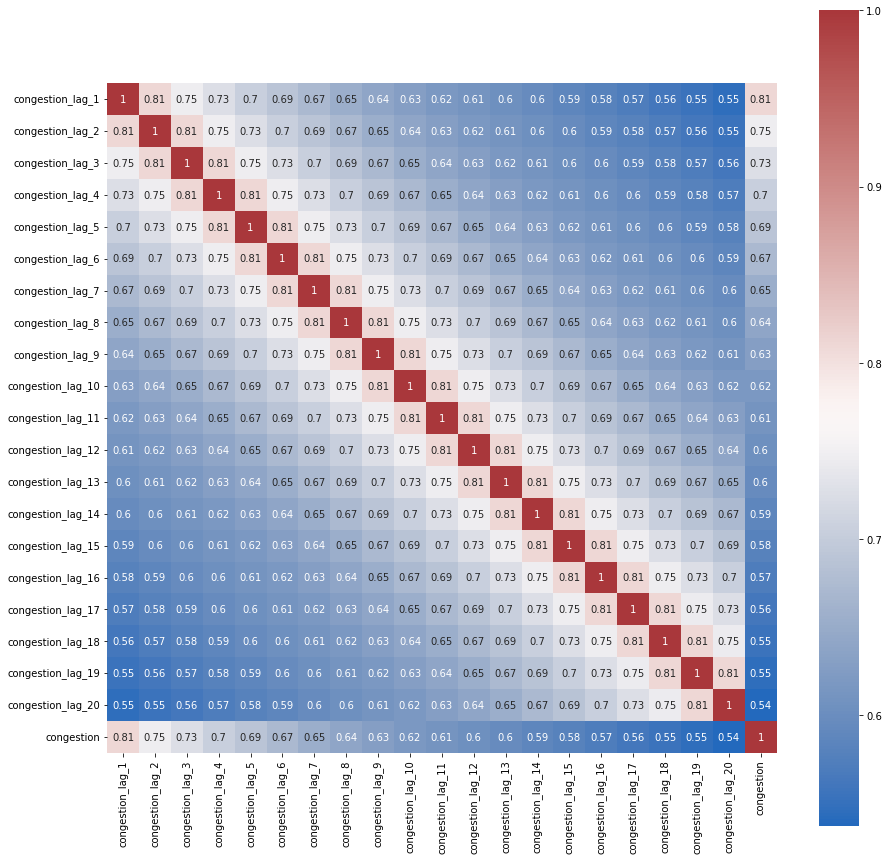

In [14]:
# check correlations
#fig, ax = plt.subplots(1, 1, figsize=(7, 7))
#ax.hist2d(training['congestion'], training['congestion_lag'], bins=(24, 50))
#ax.set_ylabel('Congestion (Time t-20mins)')
#ax.set_xlabel('Congestion (Time t)')
#plt.show()
lags = [ 'congestion_lag_' + str(v+1) for v in range(nlags) ]
lags.append('congestion')
lag_view = training[lags]
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
sns.heatmap(lag_view.corr(), cmap=sns.color_palette("vlag", as_cmap=True), square=True, ax=ax, annot=True)
plt.show()

In [15]:
# dropping features
X = training.drop(['time', 'direction', 'month', 'congestion'], axis=1)
X = X.drop(
    [ f'congestion_lag_{v}' for v in range(4, nlags+1) ],
    axis=1
)
y = training['congestion']

# train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
print(X_train)

        x  y  day  hour  road_labels  congestion_lag_1  congestion_lag_2  \
175757  2  3    2    17            5              77.0              80.0   
598986  0  3    2     7            3              25.0              22.0   
526044  2  3    0    17            7              55.0              37.0   
551718  2  3    6     4            6              17.0              17.0   
77082   2  2    2    11            6              52.0              54.0   
...    .. ..  ...   ...          ...               ...               ...   
374243  1  3    3     5            7              37.0              30.0   
559313  2  2    0    19            2              34.0              37.0   
314608  0  2    4    10            1              53.0              54.0   
149096  2  2    3    23            3              58.0              54.0   
284242  2  3    4    22            5              70.0              68.0   

        congestion_lag_3  congestion_lag_20  
175757              75.0               70

# hyperparameter tuning

In [17]:
# defining search space
from hyperopt import hp
#mln = [v + 1 for v in range(1, 20)]
#mln.append(None)
#print(mln)

params = {
    'n_estimators'   : hp.quniform('n_estimators', 25, 100, 25),
    'max_depth'      : hp.quniform('max_depth', 1, 20, 2),
    #'max_leaf_nodes' : hp.choice('max_leaf_nodes', mln),
}

# Objective function

In [18]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from hyperopt import STATUS_OK

def objective(params):
    global X_train, y_train, X_test, y_test
    
    print(f'Running with {params}')
    
    params['n_estimators']   = int(params['n_estimators'])
    params['max_depth']      = int(params['max_depth'])
    
    """if params['max_leaf_nodes'] is not None:
        params['max_leaf_nodes'] = int(params['max_leaf_nodes'])
"""    
    # fit model
    model = XGBRegressor(**params, random_state=42, verbosity=1)
    #model = XGBRegressor(**params, random_state=42, verbosity=1, tree_method='gpu_hist')
    #model = GradientBoostingRegressor(**params, random_state=42)
    #model = RandomForestRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    
    # make predictions with fitted model
    y_pred = model.predict(X_test)
    del model
    
    # return metrics
    return {
        'loss'     : mean_absolute_error(y_pred, y_test),
        'status'   : STATUS_OK,
        'RMSE'     : mean_squared_error(y_pred, y_test, squared=False)
        }

# Run trials

In [19]:
"""from hyperopt import fmin, tpe, Trials

trials = Trials()
best = fmin(objective,
            space = params,
            algo = tpe.suggest,
            max_evals = 50,
            trials = trials)
print(best)
# GPU memory issues seem to be a known problem: https://github.com/dmlc/xgboost/issues/4668, https://stackoverflow.com/questions/63464976/xgboost-gpu-out-of-memory"""

'from hyperopt import fmin, tpe, Trials\n\ntrials = Trials()\nbest = fmin(objective,\n            space = params,\n            algo = tpe.suggest,\n            max_evals = 50,\n            trials = trials)\nprint(best)\n# GPU memory issues seem to be a known problem: https://github.com/dmlc/xgboost/issues/4668, https://stackoverflow.com/questions/63464976/xgboost-gpu-out-of-memory'

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
# fit mode
model = XGBRegressor(max_depth=18, n_estimators=75, random_state=42, verbosity=1, tree_method='gpu_hist')
model.fit(X_train, y_train)


In [ ]:
# make predictions with fitted model
y_pred = model.predict(X_test)

print(mean_absolute_error(y_pred, y_test))
print(mean_squared_error(y_pred, y_test, squared=False))

In [ ]:
# seems to work OK
# TODO, create lags from testing data, autoregressive needed? These are notoriously sensitive to initial prediction inaccuracies